# ファジィ推論

## ファジィ推論パッケージ`UPA Fuzzy Systems`のインストール

In [1]:
!pip install UPAFuzzySystems

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=ace42877328d6efca6e9c6aa1fda7251eb0b0eb927095c882854d93cb62914c1
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


## パッケージのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import UPAFuzzySystems as UPAfs

## 例題：車間距離と速度を考慮した車の運転ロジック
車間距離と速度を考慮した車の運転ロジックをファジィ推論で実現する。この運転ロジックとして、次のような規則を仮定する。
<dl>
<dt>規則1</dt>
<dd>車間距離が<u>狭く</u>て速度が<u>遅い</u>ならば、アクセルを保持せよ（速度を<u>保持</u>せよ）</dd>
<dt>規則2</dt>
<dd>車間距離が<u>狭く</u>て速度が<u>速い</u>ならば、ブレーキを踏め（<u>減速</u>せよ）</dd>
<dt>規則3</dt>
<dd>車間距離が<u>広く</u>て速度が<u>遅い</u>ならば、アクセルを踏み込め（<u>加速</u>せよ）</dd>
<dt>規則4</dt>
<dd>車間距離が<u>広く</u>て速度が<u>速い</u>ならば、アクセルを保持せよ（速度を<u>保持</u>せよ）</dd>
</dl>
この4つの規則は言葉で書かれているので、このままではファジィ推論を実行することができない。そこで、上の言語規則の"狭い"、"広い"、"遅い"、"速い"、"速度を保持せよ"、"減速せよ"、"加速せよ"などの推論情報として必要なものを、ファジィ集合として表現する必要がある。本例題では、これらのファジィ集合を次のようなメンバーシップ関数で定義する。



<img src="http://www.ssc.ecs.kyutech.ac.jp/store/img/mem_func.png" width="800" alt="membership_function">

x: 車間距離<br>
y: 速度<br>
z: 速度調整指令（アクセルあるいはブレーキの操作）<br>
とし、それぞれに対する全体集合（ユニバース`universe`）を次のように定める。<br>
$$X= \{x|0\leq x \leq 40\}$$
$$Y= \{x|0\leq x \leq 100\}$$
$$Z= \{x|-20\leq x \leq 20\}$$

### メンバーシップ関数の設定

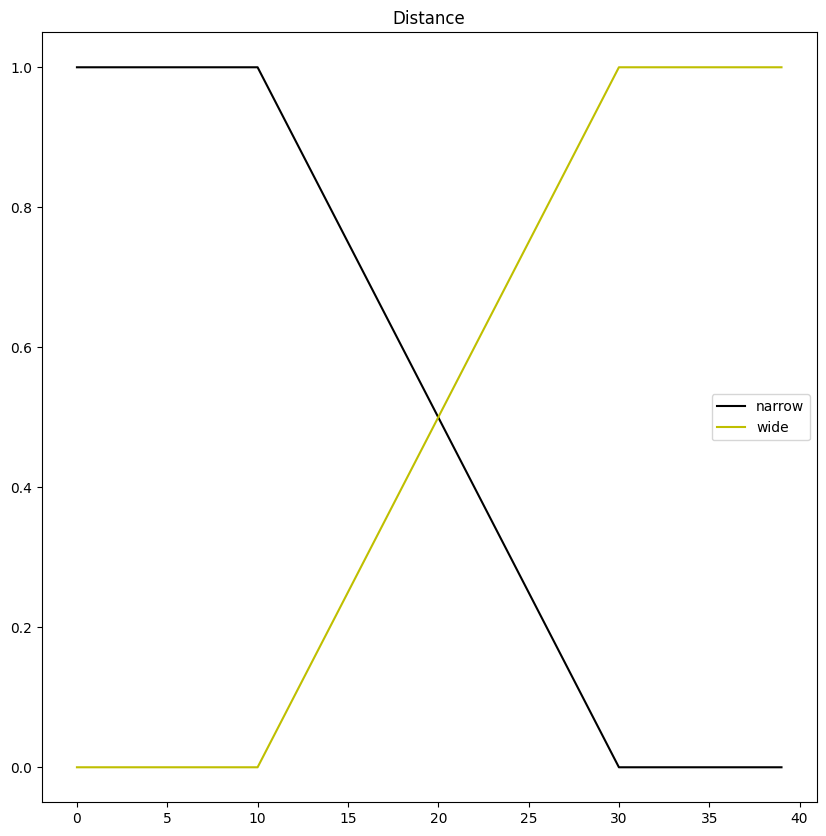

In [3]:
# 車間距離のメンバーシップ関数の作成
Dist = UPAfs.fuzzy_universe('Distance', np.arange(0,40,1), 'continuous') # ユニバースの設定
Dist.add_fuzzyset('narrow','trapmf',[0,0,10,30])  # 台形型（trapezoidal）ファジィ集合[左下, 左上, 右上, 右下]
Dist.add_fuzzyset('wide','trapmf',[10,30,40,40]) # 台形型ファジィ集合
Dist.view_fuzzy() # 描画

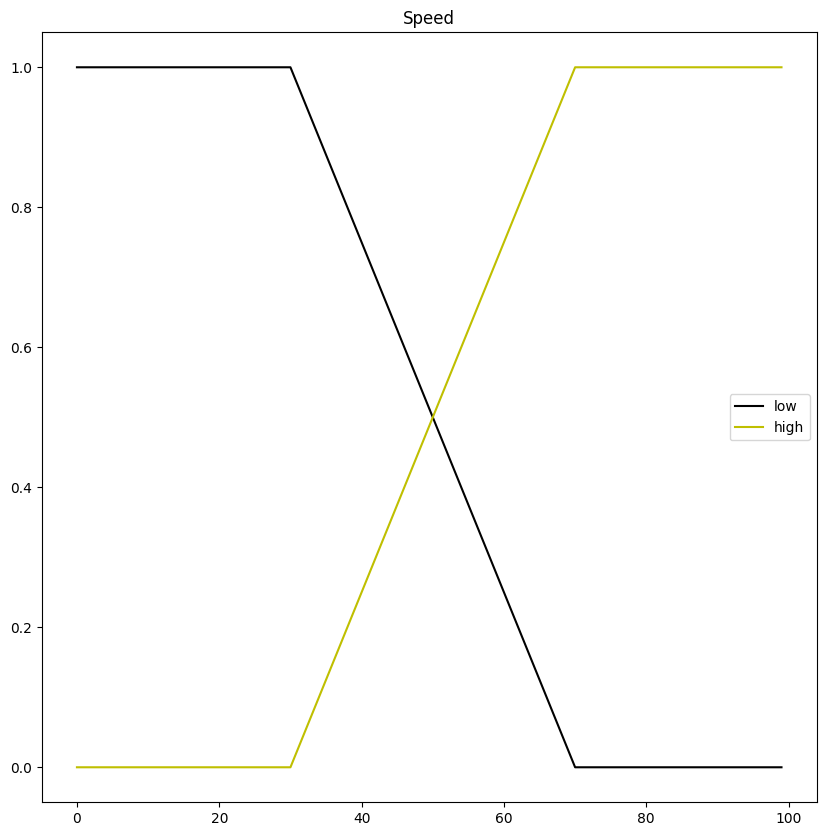

In [4]:
# 速度のファジィ集合
Speed = UPAfs.fuzzy_universe('Speed', np.arange(0,100,1), 'continuous')
Speed.add_fuzzyset('low','trapmf',[0,0,30,70])
Speed.add_fuzzyset('high','trapmf',[30,70,100,100])
Speed.view_fuzzy()

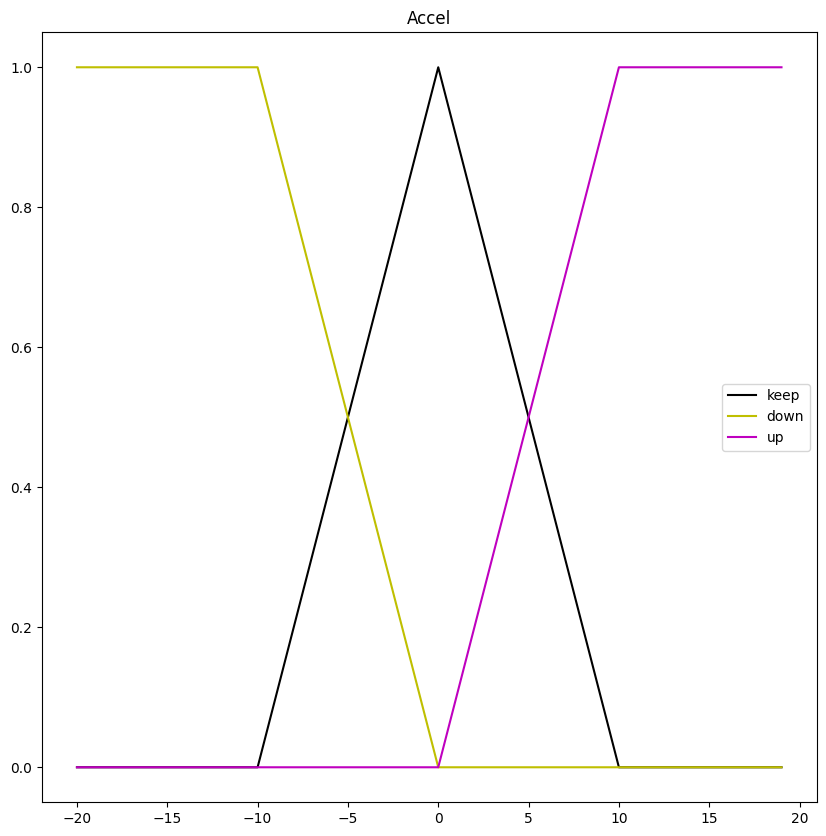

In [5]:
# 加速度のファジィ集合
Accel = UPAfs.fuzzy_universe('Accel', np.arange(-20,20,1), 'continuous')
Accel.add_fuzzyset('keep','trimf',[-10,0,10])
Accel.add_fuzzyset('down','trapmf',[-20,-20,-10,0])
Accel.add_fuzzyset('up','trapmf',[0,10,20,20])
Accel.view_fuzzy()

### 直説法によるファジィ推論（マムダニのファジィ推論）システムの設定

In [6]:
Mamdani1 = UPAfs.inference_system('Mamdani')
Mamdani1.add_premise(Dist)  # 前件部1
Mamdani1.add_premise(Speed)     # 前件部2
Mamdani1.add_consequence(Accel) # 後件部

Mamdani1.add_rule([['Distance','narrow'],['Speed','low']],['and'],[['Accel','keep']]) # 規則1
Mamdani1.add_rule([['Distance','narrow'],['Speed','high']],['and'],[['Accel','down']]) # 規則2
Mamdani1.add_rule([['Distance','wide'],['Speed','low']],['and'],[['Accel','up']]) # 規則3
Mamdani1.add_rule([['Distance','wide'],['Speed','high']],['and'],[['Accel','keep']]) # 規則4

Mamdani1.configure('Mamdani')
Mamdani1.build()

### システムの入出力関係の描画
起こりうる全ての入力（車間距離と速度）に対する出力（加速度）の全体像を俯瞰して見るために、入力をX-Y面にとり、出力をZ軸とする3次元プロットを描画する。

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

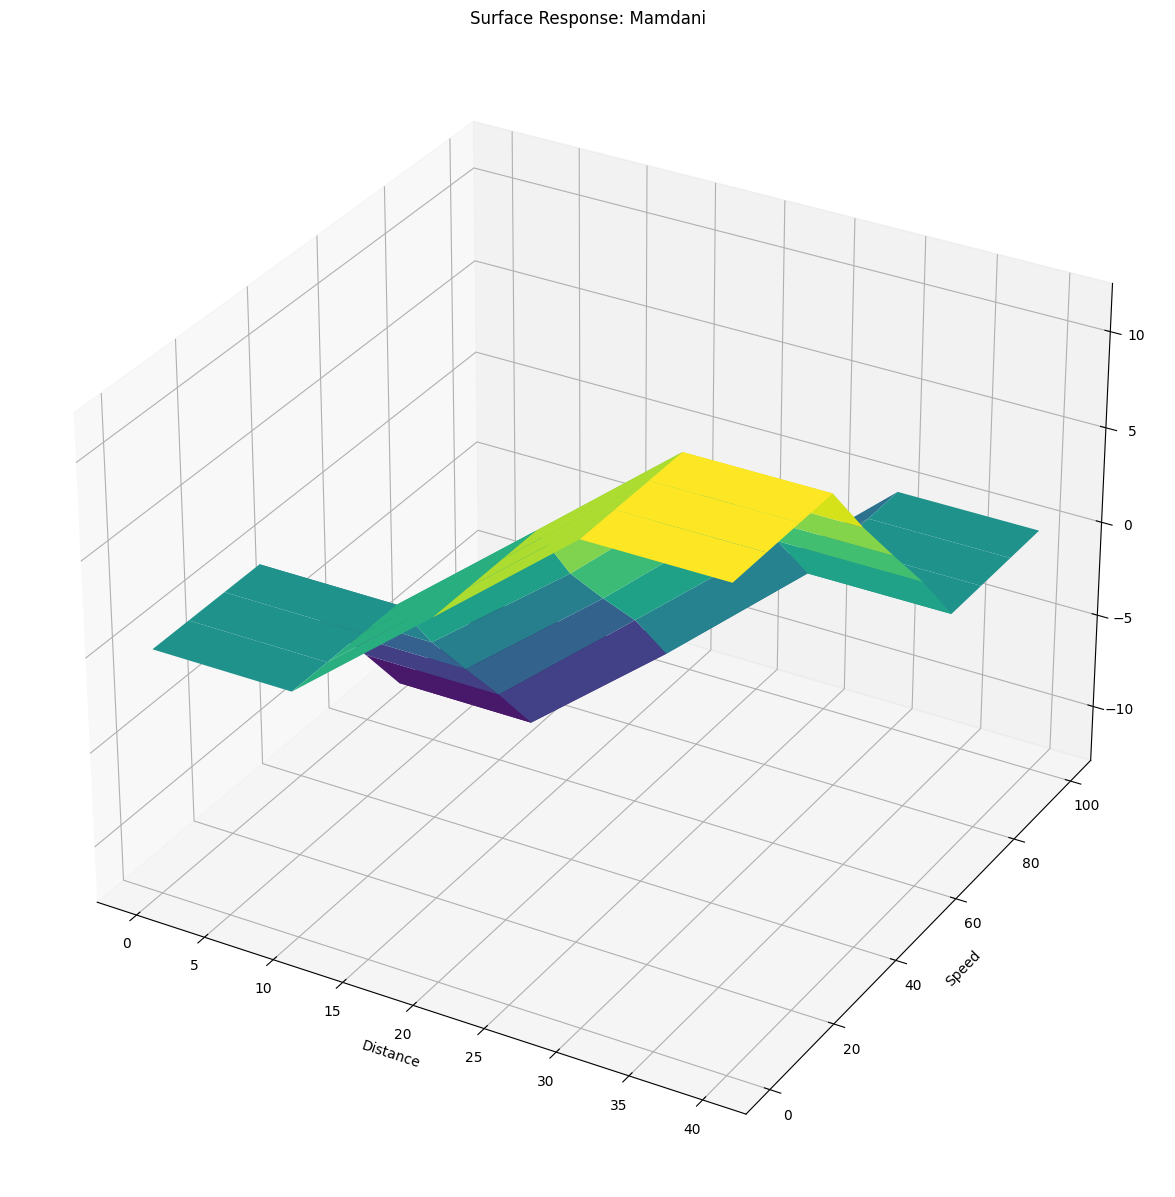

In [8]:
dist_values = np.arange(0,41,10)
speed_values = np.arange(0,101,10)

Mamdani1.surface_fuzzy_system([dist_values,speed_values])

描画結果を見ると、入力と出力が非線形の関係になっていることがわかる。

### 特定の入力に対する推論結果
車間距離が15m、速度が時速60kmの入力に対する推論結果は次のようにして得られる。車間距離15mという入力は、"狭い"と"広い"を表すファジィ集合に対して、それぞれ0.75, 0.25のメンバーシップ値となる。そこで、車間距離15mの状況を言語的に表現するならば、"やや狭い"となるだろう。同様に、速度60kmの状況を言語的に表現すれば、"やや速い"となる。この入力の状況をまとめると、"車間距離がやや狭く、速度がやや速い"と表現できる。

In [9]:
Mamdani1.fuzzy_system_sim([15,60])

array([[-5.81690141]])

推論結果は、$-5.8$となり、これを言語的に表現すれば、"やや減速せよ"と解釈できる。言語的に表現された入力状況と先に示された4つの言語規則を照らし合わせると、"やや減速せよ"という推論結果の妥当性がわかる。このように、ファジィ推論はいくつかの推論規則と与えられた入力を照らし合わせ、補間的な方法によって推論結果を導くことができる。

In [10]:
Mamdani1.structure

{'Rules': [{'antecedent': [['trapmf',
     array([ 0,  0, 10, 30]),
     array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39])],
    ['trapmf',
     array([ 0,  0, 30, 70]),
     array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]],
   'conectors': ['and'],
   'consequent': [['trimf',
     array([-10,   0,  10]),
     array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
             -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,  

## 後件部に線形関数を用いる推論法（高木・菅野のファジィ推論）
直接法でファジィ推論を行う場合、前件部変数が多くなると次のような問題が起こる。
1. 前件部変数が増えるたびに、規則数が指数関数的に増加する。
2. 規則数が増えると、規則作成の作業の手間が膨大になる。
3. 前件部変数が多くなると、一般に前件部変数と後件部変数との間の因果関係を捉えることが難しくなり、規則を作成することも難しくなる。

これらの問題を解決するために考え出されたのが、後件部に線形関数を用いる推論法である。この推論法の大きな特徴は、

1. 規則の後件部に線形の入出力関係式を用いている。
2. 入出力データを用いたモデリングによって推論規則を同定する。
3. 直説法に比べて、少ない規則数になる。



### 例題：ヒーターのスイッチ調整
次のような直接法の推論規則を仮定する。
1. IF x is "Small" and y is "Small" THEN z is "Medium"
2. IF x is "Small" and y is "Medium" THEN z is "Small"
3. IF x is "Small" and y is "Big" THEN z is "Very Small"
4. IF x is "Medium" and y is "Small" THEN z is "Big"
5. IF x is "Medium" and y is "Medium" THEN z is "Medium"
6. IF x is "Medium" and y is "Big" THEN z is "Small"
7. IF x is "Big" and y is "Small" THEN z is "Very Big"
8. IF x is "Big" and y is "Medium" THEN z is "Medium"
9. IF x is "Big" and y is "Big" THEN z is "Very Small"


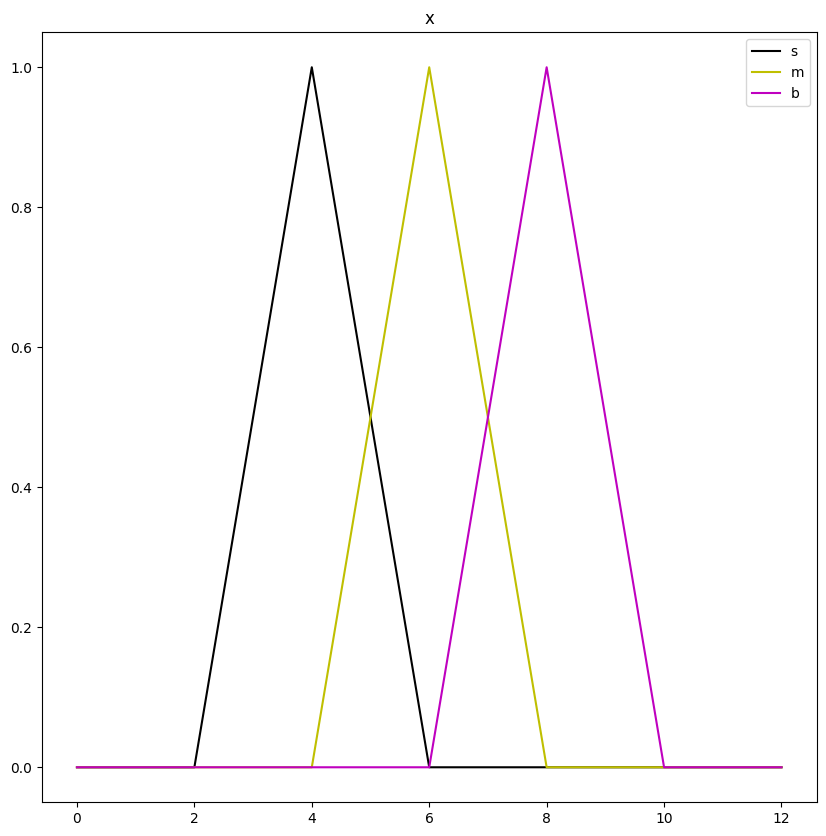

In [11]:
x = UPAfs.fuzzy_universe('x', np.arange(0,13,1), 'continuous')
x.add_fuzzyset('s','trimf',[2,4,6])     # Small
x.add_fuzzyset('m','trimf',[4,6,8])     # Medium
x.add_fuzzyset('b','trimf',[6,8,10])    # Big

x.view_fuzzy()

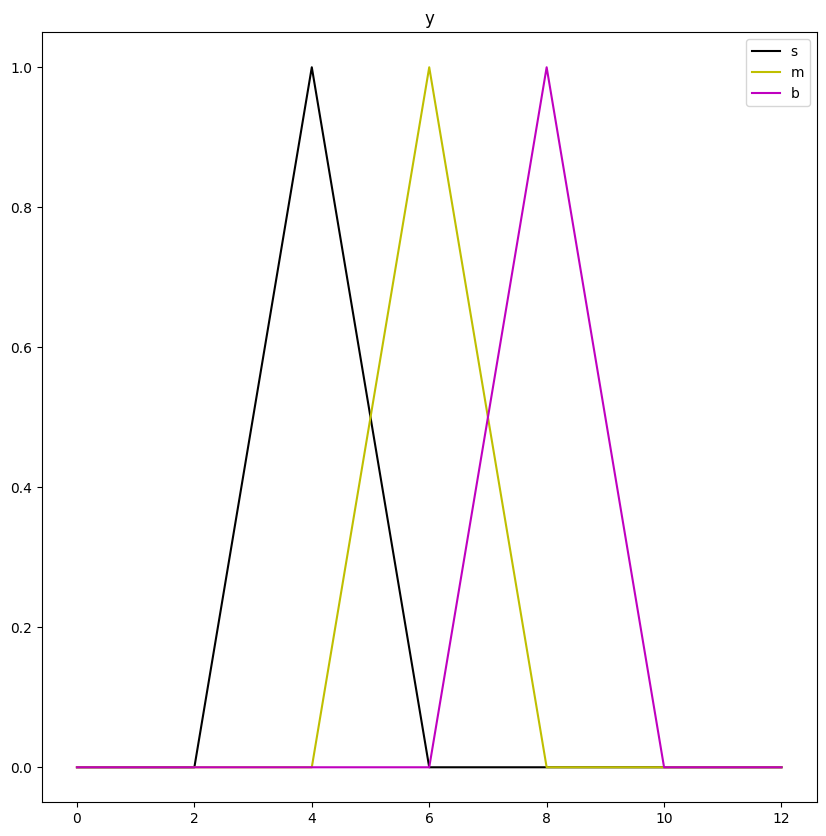

In [12]:
y = UPAfs.fuzzy_universe('y', np.arange(0,13,1), 'continuous')
y.add_fuzzyset('s','trimf',[2,4,6])     # Small
y.add_fuzzyset('m','trimf',[4,6,8])     # Medium
y.add_fuzzyset('b','trimf',[6,8,10])    # Big

y.view_fuzzy()

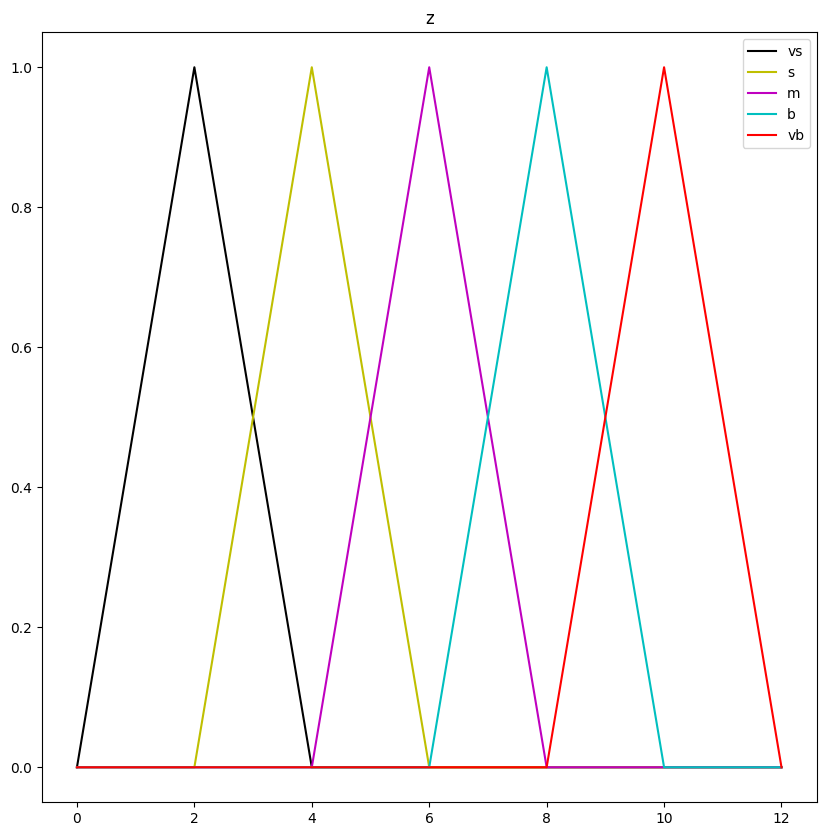

In [13]:
z = UPAfs.fuzzy_universe('z', np.arange(0,13,1), 'continuous')
z.add_fuzzyset('vs','trimf',[0,2,4])    # Very Small
z.add_fuzzyset('s','trimf',[2,4,6])     # Small
z.add_fuzzyset('m','trimf',[4,6,8])     # Medium
z.add_fuzzyset('b','trimf',[6,8,10])    # Big
z.add_fuzzyset('vb','trimf',[8,10,12])  # Very Big

z.view_fuzzy()

In [14]:
Mamdani2 = UPAfs.inference_system('Mamdani')
Mamdani2.add_premise(x)  # 前件部1
Mamdani2.add_premise(y)     # 前件部2
Mamdani2.add_consequence(z) # 後件部

Mamdani2.add_rule([['x','s'],['y','s']],['and'],[['z','m']])  # 規則1
Mamdani2.add_rule([['x','s'],['y','m']],['and'],[['z','s']])  # 規則2
Mamdani2.add_rule([['x','s'],['y','b']],['and'],[['z','vs']]) # 規則3
Mamdani2.add_rule([['x','m'],['y','s']],['and'],[['z','b']])  # 規則4
Mamdani2.add_rule([['x','m'],['y','m']],['and'],[['z','m']])  # 規則5
Mamdani2.add_rule([['x','m'],['y','b']],['and'],[['z','s']])  # 規則6
Mamdani2.add_rule([['x','b'],['y','s']],['and'],[['z','vb']]) # 規則7
Mamdani2.add_rule([['x','b'],['y','m']],['and'],[['z','m']])  # 規則8
Mamdani2.add_rule([['x','b'],['y','b']],['and'],[['z','vs']]) # 規則9

Mamdani2.configure('Mamdani')
Mamdani2.build()

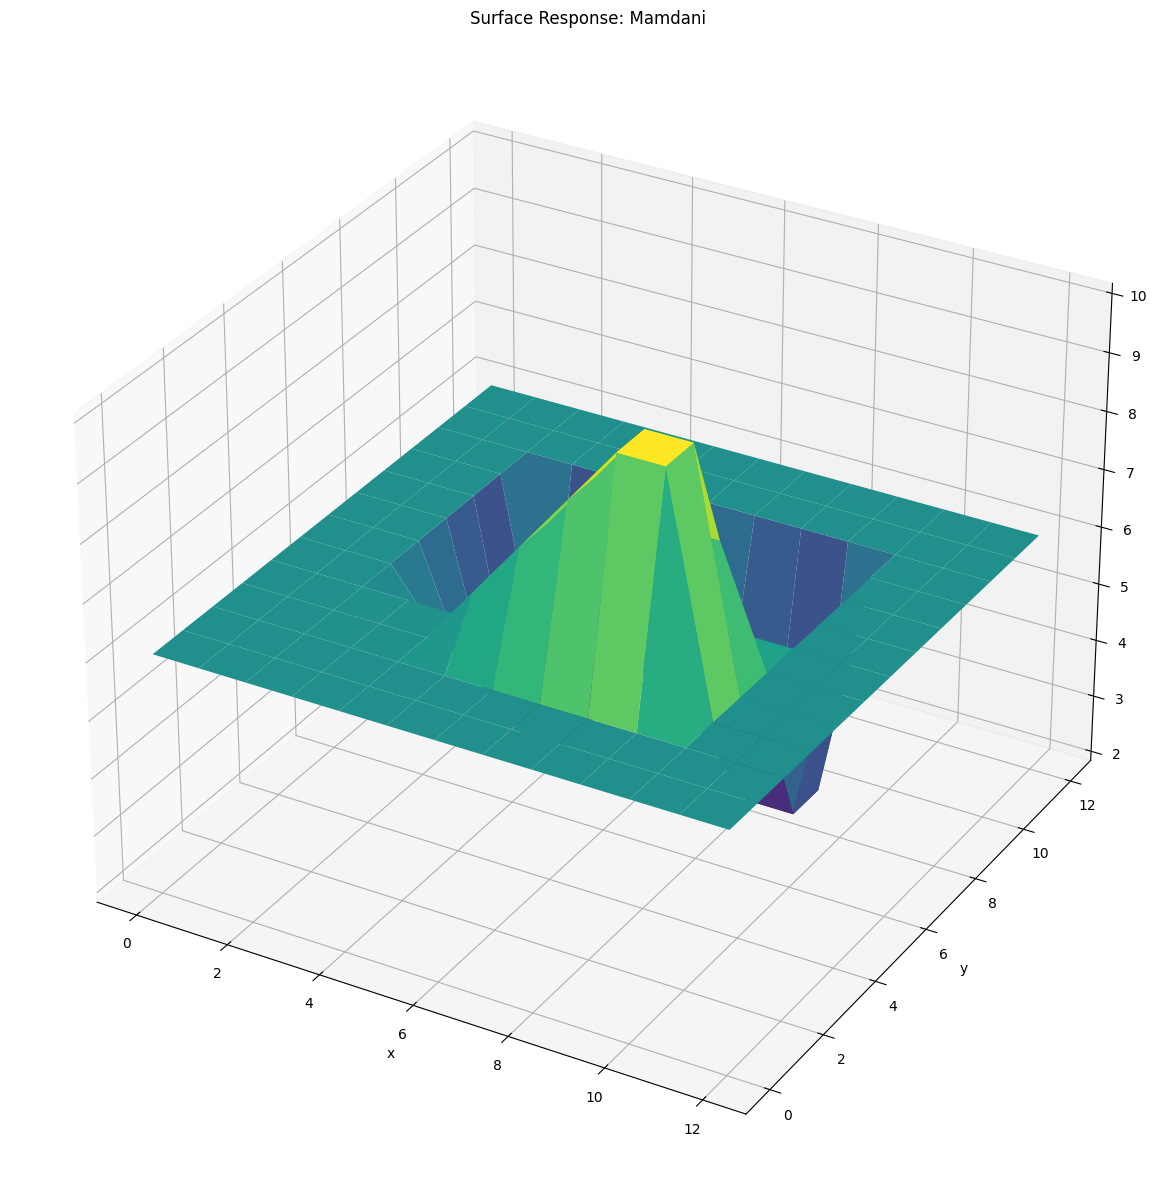

In [15]:
vol_values = np.arange(0,13,1)

Mamdani2.surface_fuzzy_system([vol_values,vol_values])

In [16]:
Mamdani2.fuzzy_system_sim([7,5])

array([[8.]])

In [17]:
x = UPAfs.fuzzy_universe('x', np.arange(0,13,1), 'continuous')
x.add_fuzzyset('sm','trapmf',[0,0,6,8])     # Small or Medium
x.add_fuzzyset('b','trapmf',[6,8,12,12])        # Big

z = UPAfs.fuzzy_universe('z', np.arange(0,13,1), 'continuous')
z.add_fuzzyset('r1','eq','-2*x[1]+18')    # rule1
z.add_fuzzyset('r2','eq','x[0]-x[1]+6')   # rule2

Sugeno1 = UPAfs.inference_system('Sugeno')
Sugeno1.add_premise(x)
Sugeno1.add_premise(y)
Sugeno1.add_consequence(z)

Sugeno1.add_rule([['x','b']],[],[['z','r1']])  # 規則1
Sugeno1.add_rule([['x','sm']],[],[['z','r2']])  # 規則1

Sugeno1.configure('Sugeno')
Sugeno1.build()

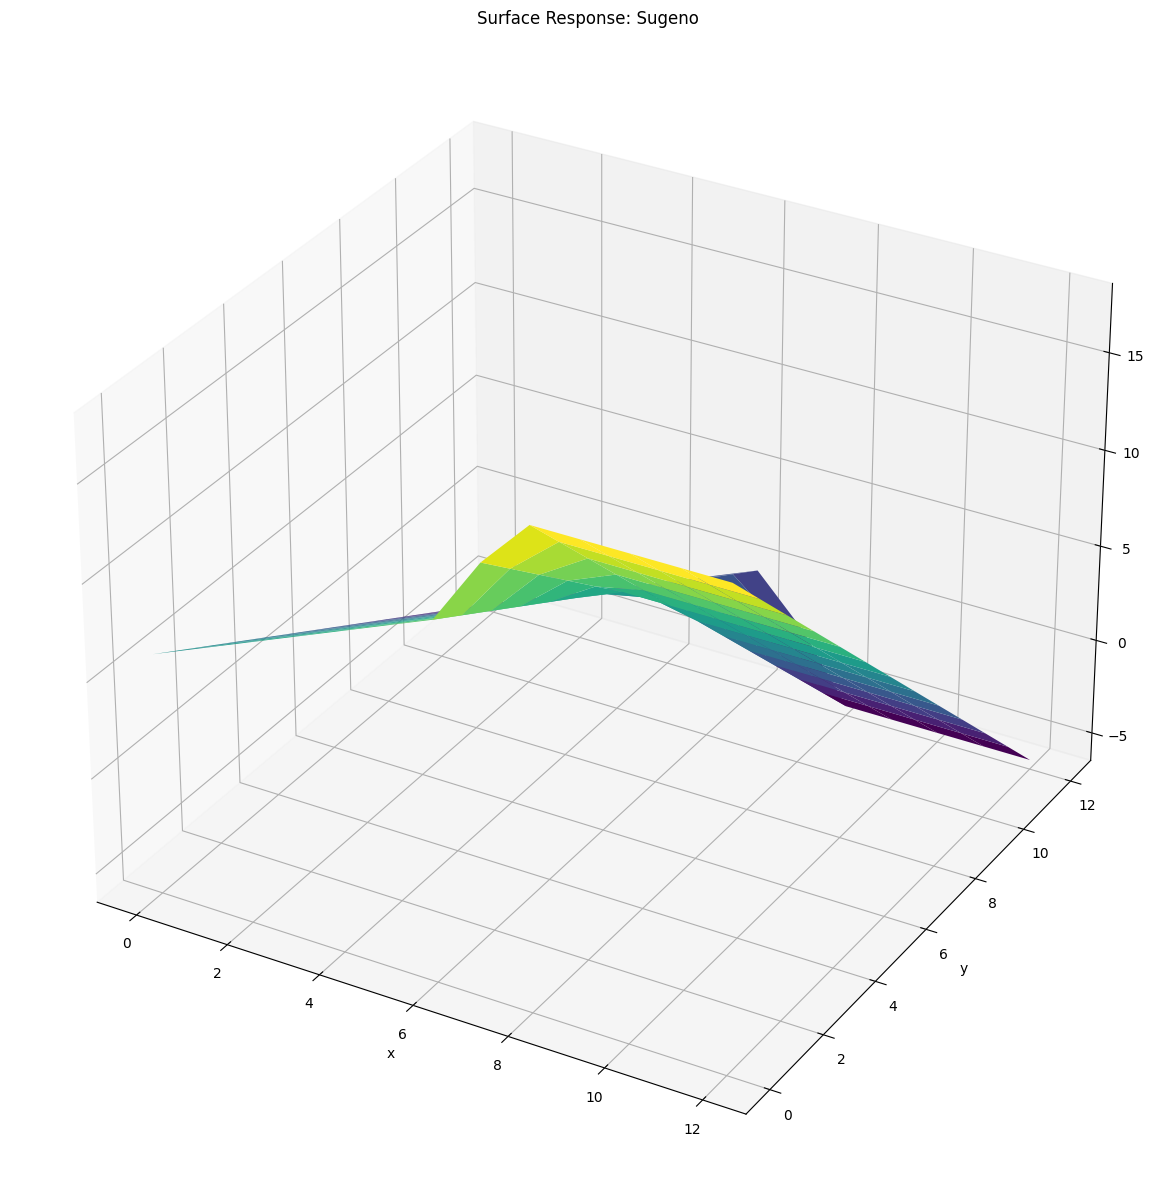

In [18]:
vol_values = np.arange(0,13,1)

Sugeno1.surface_fuzzy_system([vol_values,vol_values])

In [19]:
Sugeno1.fuzzy_system_sim([7,5])

array([[8.]])

## 簡略型ファジィ推論法

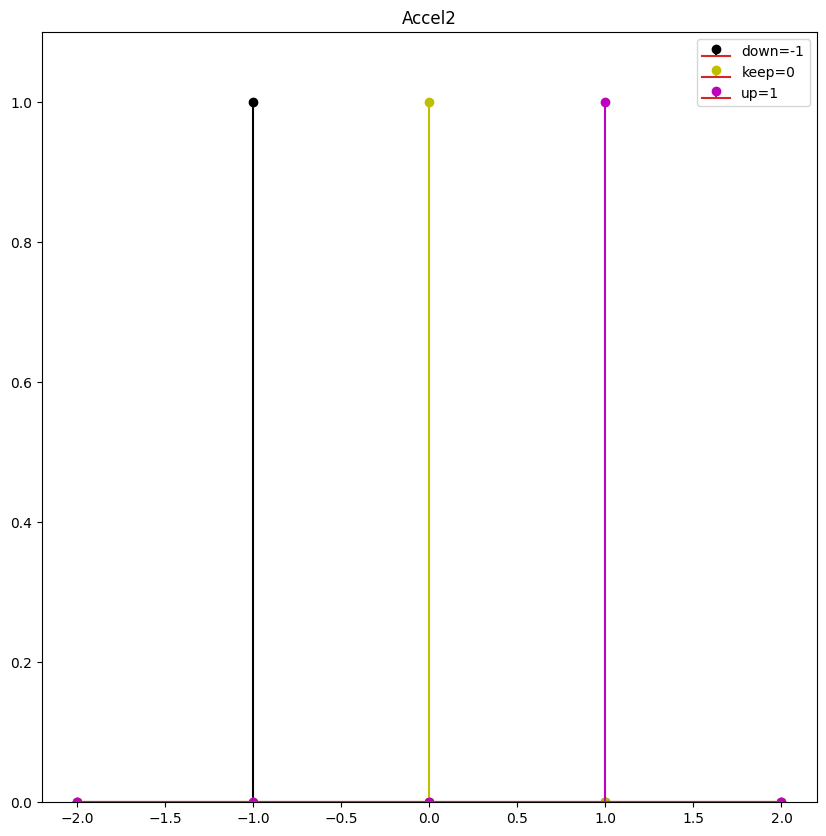

In [20]:
#Output Fuzzy Sets
Accel2 = UPAfs.fuzzy_universe('Accel2', np.arange(-2,3,1), 'continuous')
Accel2.add_fuzzyset('down','eq','-1')
Accel2.add_fuzzyset('keep','eq','0')
Accel2.add_fuzzyset('up','eq','1')

Accel2.view_fuzzy()

In [21]:
#Defining Rules and Building Inference System
Linear1 = UPAfs.inference_system('Linear')
Linear1.add_premise(Curve)
Linear1.add_premise(Speed)
Linear1.add_consequence(Accel2)

Linear1.add_rule([['Curve','sharp'],['Speed','low']],['and'],[['Accel2','keep']]) # rule1
Linear1.add_rule([['Curve','sharp'],['Speed','high']],['and'],[['Accel2','down']]) # rule2
Linear1.add_rule([['Curve','gentle'],['Speed','low']],['and'],[['Accel2','up']]) #rule3
Linear1.add_rule([['Curve','gentle'],['Speed','high']],['and'],[['Accel2','keep']]) #rule4

Linear1.configure('Linear')
Linear1.build()

NameError: ignored

In [ ]:
curve_values = np.arange(0,180,10)
speed_values = np.arange(0,120,10)

Linear1.surface_fuzzy_system([curve_values,speed_values])

In [ ]:
Linear1.fuzzy_system_sim([10,70])

In [ ]:
Linear1.fuzzy_system_sim([60,50])

In [ ]:
Linear1.fuzzy_system_sim([30,30])